In [1]:
# Create Generative Adversarial Network (GAN) to generate new images of handwritten digits
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5
test_images = (test_images - 127.5) / 127.5

# Reshape the images to (28, 28, 1)
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)
sample_size = 100
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)


2024-01-17 15:00:22.494234: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-17 15:00:22.494335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-17 15:00:22.562204: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-17 15:00:22.648431: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 15:00:31.488608: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.15.0


In [2]:
# init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
generator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(7 * 7 * 256, input_shape=(sample_size,)),
    tf.compat.v1.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Reshape((7, 7, 256)),
    
    tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
    tf.compat.v1.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    
    tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'),
    tf.compat.v1.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    
    tf.keras.layers.Conv2D(1, (7, 7), activation='tanh', padding='same')
])

generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       524416    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 128)       5

2024-01-17 01:08:51.549795: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 12544)             1266944   


 batch_normalization (Batch  (None, 12544)             50176     


 Normalization)                                                  


 leaky_re_lu (LeakyReLU)     (None, 12544)             0         


 reshape (Reshape)           (None, 7, 7, 256)         0         


 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       524416    


 anspose)                                                        


 batch_normalization_1 (Bat  (None, 14, 14, 128)       512       


 chNormalization)                                                


 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         


 conv2d_transpose_1 (Conv2D  (None, 28, 28, 64)        131136    


 Transpose)                                                      


 batch_normalization_2 (Bat  (None, 28, 28, 64)        256       


 chNormalization)                                                


 leaky_re_lu_2 (LeakyReLU)   (None, 28, 28, 64)        0         


 conv2d (Conv2D)             (None, 28, 28, 1)         3137      


Total params: 1976577 (7.54 MB)


Trainable params: 1951105 (7.44 MB)


Non-trainable params: 25472 (99.50 KB)


_________________________________________________________________


2024-01-17 01:08:51.549795: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5


In [3]:
# init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=(28, 28, 1)),
    tf.compat.v1.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'),
    tf.compat.v1.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.5),
    
    
    # tf.keras.layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.LeakyReLU(alpha=0.2),
    # tf.keras.layers.Dropout(0.5),

    # tf.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.LeakyReLU(alpha=0.2),
    
    # tf.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.LeakyReLU(alpha=0.2),
    
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       2176      
                                                                 
 batch_normalization_3 (Bat  (None, 14, 14, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         524544    
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 256)         1024      
 chNormalization)                                     

_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d_1 (Conv2D)           (None, 14, 14, 128)       2176      


 batch_normalization_3 (Bat  (None, 14, 14, 128)       512       


 chNormalization)                                                


 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         


 dropout (Dropout)           (None, 14, 14, 128)       0         


 conv2d_2 (Conv2D)           (None, 7, 7, 256)         524544    


 batch_normalization_4 (Bat  (None, 7, 7, 256)         1024      


 chNormalization)                                                


 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 256)         0         


 dropout_1 (Dropout)         (None, 7, 7, 256)         0         


 flatten (Flatten)           (None, 12544)             0         


 dense_1 (Dense)             (None, 1)                 12545     


Total params: 540801 (2.06 MB)


Trainable params: 540033 (2.06 MB)


Non-trainable params: 768 (3.00 KB)


_________________________________________________________________


In [4]:
# def create_gan(gen,disc):
#     disc.trainable = False
#     gan = tf.keras.models.Sequential([gen, disc])
#     gan.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])
#     return gan
# gan = create_gan(generator,discriminator)

gan = tf.keras.models.Sequential([generator, discriminator])
# gan.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])
gan.summary()

discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         1976577   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 540801    
                                                                 
Total params: 2517378 (9.60 MB)
Trainable params: 2491138 (9.50 MB)
Non-trainable params: 26240 (102.50 KB)
_________________________________________________________________


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 sequential (Sequential)     (None, 28, 28, 1)         1976577   


 sequential_1 (Sequential)   (None, 1)                 540801    


Total params: 2517378 (9.60 MB)


Trainable params: 2491138 (9.50 MB)


Non-trainable params: 26240 (102.50 KB)


_________________________________________________________________


In [5]:
# discriminator.compiled_metrics._metrics
tf.keras.utils.disable_interactive_logging()
from IPython.display import clear_output

num_iterations = 100
batch_size = 128
smooth = 0.1
total = train_images.shape[0]//batch_size
l1_hist = []
l2_hist = []
l3_hist = []
ac1_hist = []
ac2_hist = []

Iteration: 99


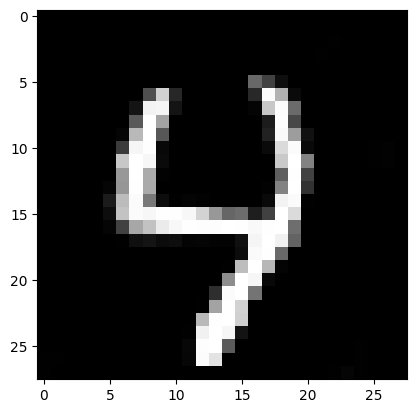

Discriminator prediction: [[0.5291898]]


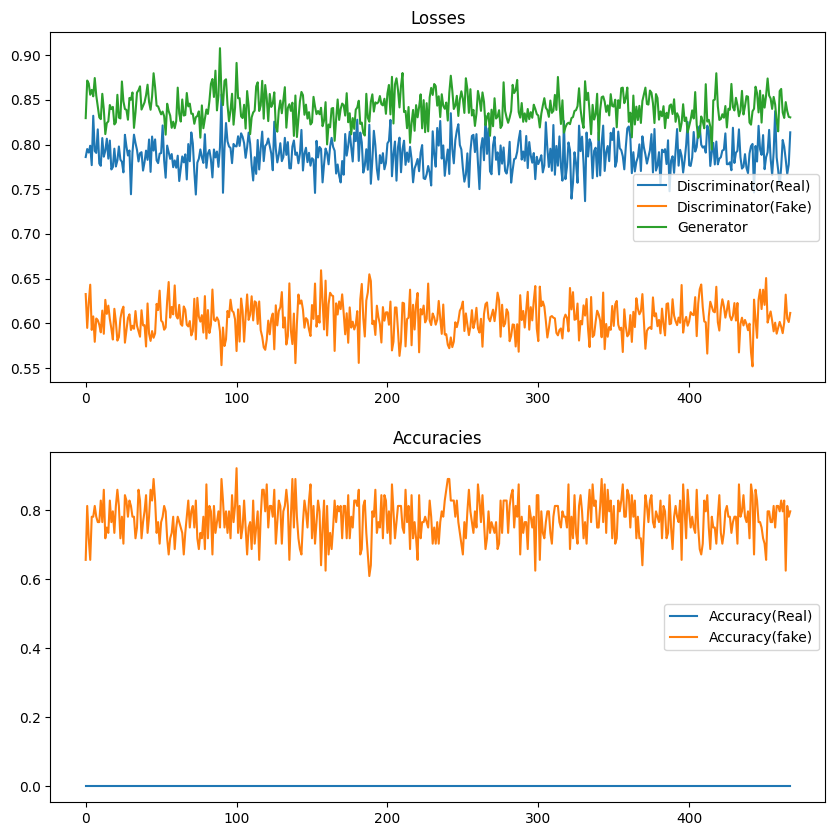

In [ ]:

for i in range(num_iterations):
    print("Iteration:", i)
    # Train the discriminator
    # Get a random batch of images
    # for layer in discriminator.layers:
    #     layer.trainable = True
    
    for k in range(total):
        # print(k,"/",total,end="\r")
        idx = np.random.randint(0, train_images.shape[0], batch_size//2)
        real_images = train_images[idx]

        # Generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size//2, sample_size))
        fake_images = generator.predict(noise)

        # Train the discriminator
        # l1, ac1 = discriminator.train_on_batch(real_images, np.ones((batch_size//2, 1))*(1 - (np.random.random()*smooth)))
        l1, ac1 = discriminator.train_on_batch(real_images, np.ones((batch_size//2, 1))*(1 - smooth))
        
        # l2, ac2 = discriminator.train_on_batch(fake_images, np.zeros((batch_size//2, 1)) + (np.random.random()*smooth))
        l2, ac2 = discriminator.train_on_batch(fake_images, np.zeros((batch_size//2, 1)) )
        
        # print(discriminator.metric_names)
        # print("Discriminator: ", l1,l2)
        
    # for layer in discriminator.layers:
    #     layer.trainable = False
        noise = np.random.normal(0, 1, (batch_size, sample_size))
        l3 = gan.train_on_batch(noise, np.ones((batch_size, 1)))
        # print(i,k,l1,l2,l3,ac1,ac2)
        # clear_output(wait=True)
        l1_hist.append(l1)
        l2_hist.append(l2)
        l3_hist.append(l3)
        ac1_hist.append(ac1)
        ac2_hist.append(ac2)
        # print("Generator: ",l3)
        # if i % 100 == 0:
        #     clear_output(wait=True)
        #     noise = np.random.normal(0, 1, (1, sample_size))
        #     plt.imshow(generator.predict(noise).reshape(28, 28), cmap='gray')
        #     plt.show()
        # inp = input()
        # if inp == "Y":
        #     continue
        # else:
        #     break
    # noise = np.random.normal(0, 1, (1, sample_size))
    # plt.imshow(generator.predict(noise).reshape(28, 28), cmap='gray')
    # plt.show()
    
    # Show plots of the losses and accuracies
    noise = np.random.normal(0, 1, (1, sample_size)) 
    created_img = generator.predict(noise)
    plt.imshow(created_img.reshape(28, 28), cmap='gray')
    plt.show()
    pred = discriminator.predict(created_img)
    print("Discriminator prediction:", pred)
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    plt.plot(l1_hist, label="Discriminator(Real)")
    plt.plot(l2_hist, label="Discriminator(Fake)")
    plt.plot(l3_hist, label="Generator")
    plt.legend()
    plt.title("Losses")
    plt.subplot(2, 1, 2)
    plt.plot(ac1_hist, label="Accuracy(Real)")
    plt.plot(ac2_hist, label="Accuracy(fake)")
    plt.legend()
    plt.title("Accuracies")
    plt.show()
    l1_hist = []
    l2_hist = []
    l3_hist = []
    ac1_hist = []
    ac2_hist = []
    
    
    
    
    # idx = np.random.randint(0, test_images.shape[0], batch_size)
    # real_images = test_images[idx]
    # noise = np.random.normal(0, 1, (batch_size, 100))
    # fake_images = generator.predict(noise)
    
    # d_loss = discriminator.test_on_batch(real_images, np.ones((batch_size, 1))*(1-smooth))
    # d_loss += discriminator.test_on_batch(fake_images, np.zeros((batch_size, 1)))
    # g_loss = gan.test_on_batch(noise, np.ones((batch_size, 1)))
    # print("Iteration:", i, "Discriminator loss:", d_loss, "Generator loss:", g_loss)

In [7]:
generator.save("generator_new.keras")
discriminator.save("discriminator_new.keras")
# import tensorflow as tf
# import numpy as np
# generator = tf.keras.models.load_model("generator_new.h5")
# discriminator = tf.keras.models.load_model("discriminator_new.h5")

In [8]:
# plt.plot(ac1_hist, label="Discriminator")
# plt.plot(ac2_hist, label="Generator")
# plt.legend()
# plt.title("Accuracies")
# plt.show()


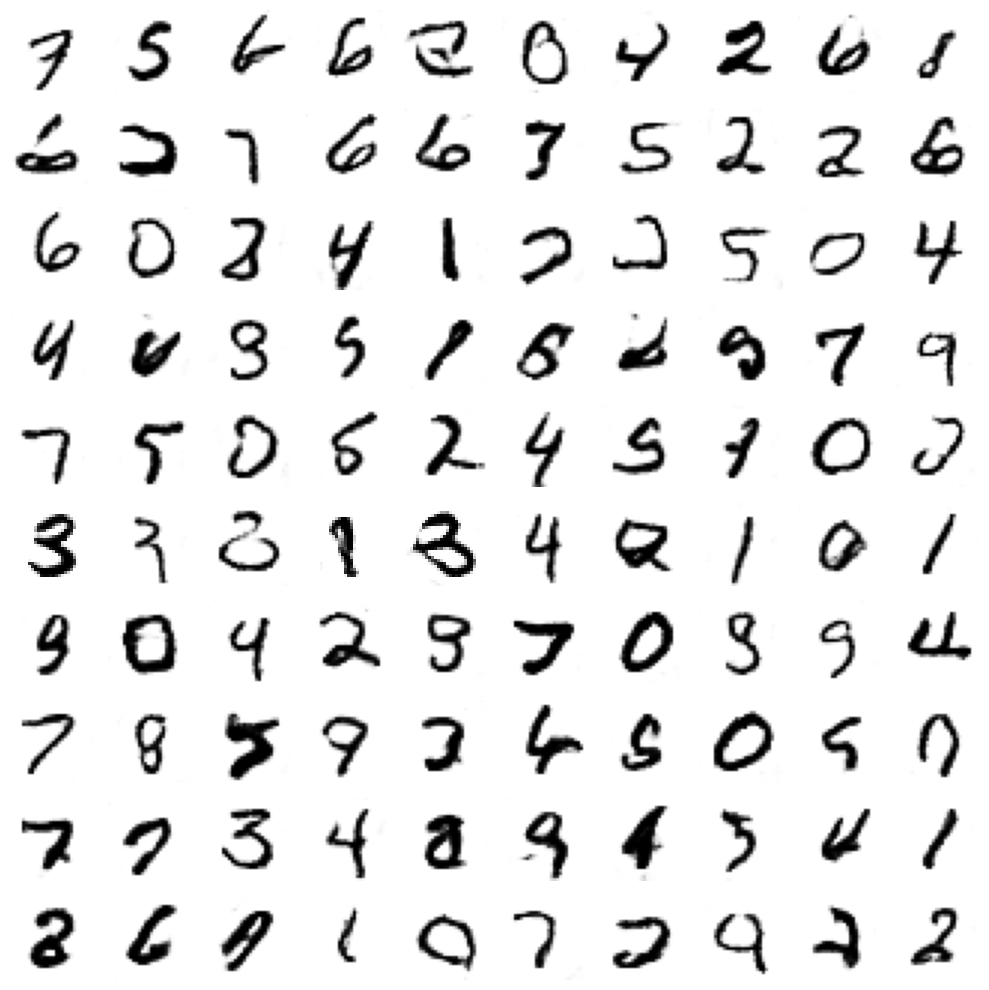

In [9]:
# Generate some images with the trained GAN
noise = np.random.normal(0, 1, (100, sample_size))
generated_images = generator.predict(noise)
generated_images = (generated_images * 127.5) + 127.5
# Show the images
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Show real images
# plt.figure(figsize=(10, 10))
# for i in range(100):
#     plt.subplot(10, 10, i+1)
#     plt.imshow(train_images[i, :, :, 0], cmap='gray_r')
#     plt.axis('off')
# plt.tight_layout()
# plt.show()


In [10]:
noise = np.random.normal(0, 1, (1000, sample_size))
fake_images = generator.predict(noise)
pred = discriminator.predict(fake_images)
print(pred)
# cnt = np.sum(pred > 0.5)
# print(cnt)

[[0.48117805]
 [0.45552185]
 [0.45191145]
 [0.41996917]
 [0.5182162 ]
 [0.45638892]
 [0.46000797]
 [0.51108485]
 [0.48070753]
 [0.4472469 ]
 [0.4721701 ]
 [0.4672381 ]
 [0.4586365 ]
 [0.46279937]
 [0.4160478 ]
 [0.43012422]
 [0.5335177 ]
 [0.48122475]
 [0.49535036]
 [0.459316  ]
 [0.47533932]
 [0.4586425 ]
 [0.4520558 ]
 [0.47317764]
 [0.4791254 ]
 [0.49022475]
 [0.5029033 ]
 [0.43737566]
 [0.50422657]
 [0.45844594]
 [0.47438076]
 [0.47728688]
 [0.46214983]
 [0.44193318]
 [0.51605487]
 [0.487018  ]
 [0.47628328]
 [0.4748857 ]
 [0.46950245]
 [0.46906158]
 [0.4399331 ]
 [0.5008574 ]
 [0.5445112 ]
 [0.47463867]
 [0.45880133]
 [0.49077424]
 [0.48222956]
 [0.41934544]
 [0.4221483 ]
 [0.46065202]
 [0.4523088 ]
 [0.45059174]
 [0.43508068]
 [0.45816433]
 [0.52877086]
 [0.45994955]
 [0.4135693 ]
 [0.45505303]
 [0.4625605 ]
 [0.43463758]
 [0.46437478]
 [0.46494064]
 [0.47450086]
 [0.49561676]
 [0.4641555 ]
 [0.500199  ]
 [0.4634866 ]
 [0.5058906 ]
 [0.43626446]
 [0.46674594]
 [0.43586865]
 [0.44

In [11]:
# generator.save('generator.keras')
# discriminator.save('discriminator.keras')

[[0.4842646 ]
 [0.5305926 ]
 [0.49029127]
 [0.4988614 ]
 [0.4750525 ]
 [0.49906975]
 [0.45722458]
 [0.4679407 ]
 [0.44656873]
 [0.4270106 ]]


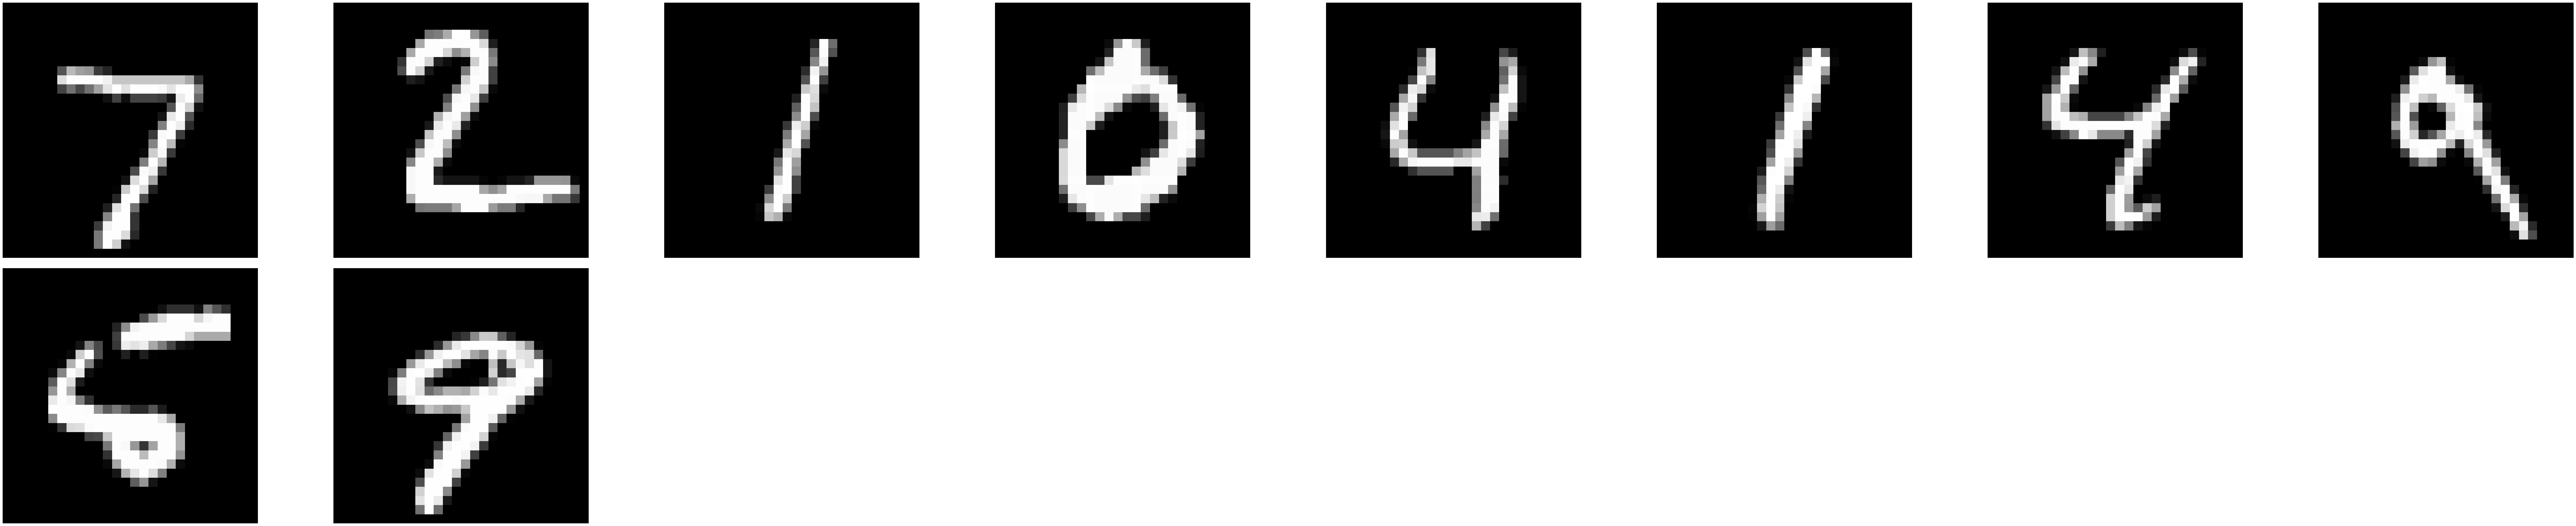

In [12]:
pred = discriminator.predict(test_images[:10])
print(pred)
plt.figure(figsize=(100, 100))
for i in range(10):
    plt.subplot(10, 8, i+1)
    plt.imshow(test_images[i, :, :, 0], cmap='gray')
    plt.tight_layout()
    plt.axis('off')